In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.cluster import KMeans

In [23]:
# Load the dataset
df = pd.read_csv("scrubbed.csv", low_memory=False)

In [24]:
# Clean the dataset
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce") # Convert datetime column to datetime format
df["country"] = df["country"].fillna("unknown") # Fill missing values in country column with "unknown"
df["shape"] = df["shape"].fillna("other") # Fill missing values in shape column with "other"
df["duration (seconds)"] = pd.to_numeric(df["duration (seconds)"], errors="coerce") # Convert duration column to numeric format

In [25]:
# Create a new column for year
df["year"] = df["datetime"].dt.year

In [26]:
# Filter out rows with missing or invalid values
df = df[(df["datetime"].notnull()) & (df["country"] != "unknown") & (df["shape"] != "other") & (df["duration (seconds)"].notnull()) & (df["year"].notnull())]


In [27]:
# Reset the index
df = df.reset_index(drop=True)


In [28]:
# Explore the dataset
print(df.shape) # (63553, 12)
print(df.columns) # ['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)', 'duration (hours/min)', 'comments', 'date posted', 'latitude', 'longitude', 'year']
print(df.head())

(63636, 12)
Index(['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude ', 'year'],
      dtype='object')
             datetime                  city state country     shape   
0 1949-10-10 20:30:00            san marcos    tx      us  cylinder  \
1 1955-10-10 17:00:00  chester (uk/england)   NaN      gb    circle   
2 1956-10-10 21:00:00                  edna    tx      us    circle   
3 1960-10-10 20:00:00               kaneohe    hi      us     light   
4 1961-10-10 19:00:00               bristol    tn      us    sphere   

   duration (seconds) duration (hours/min)   
0              2700.0           45 minutes  \
1                20.0           20 seconds   
2                20.0             1/2 hour   
3               900.0           15 minutes   
4               300.0            5 minutes   

                                            comments date posted    latitude   
0  T

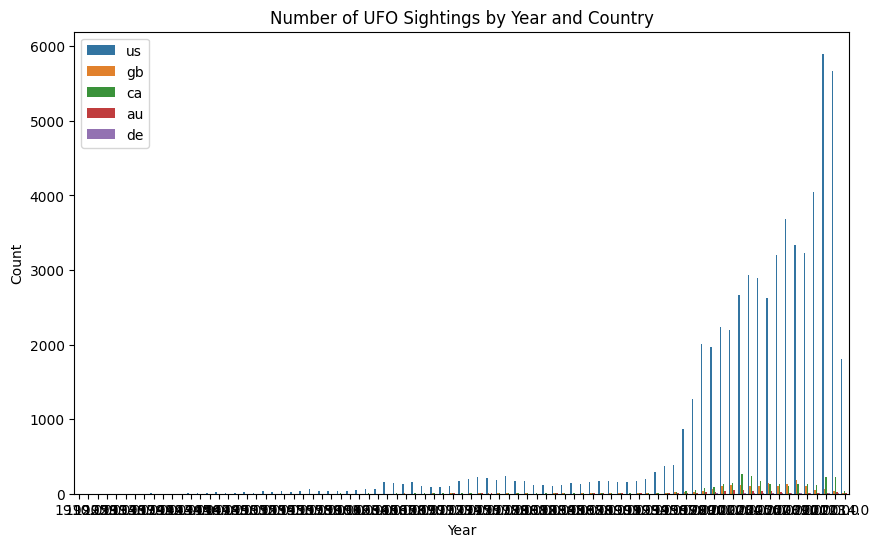

In [29]:
# Visualize the number of sightings by year and country
plt.figure(figsize=(10,6))
sns.countplot(x="year", hue="country", data=df)
plt.title("Number of UFO Sightings by Year and Country")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(loc="upper left")
plt.show()


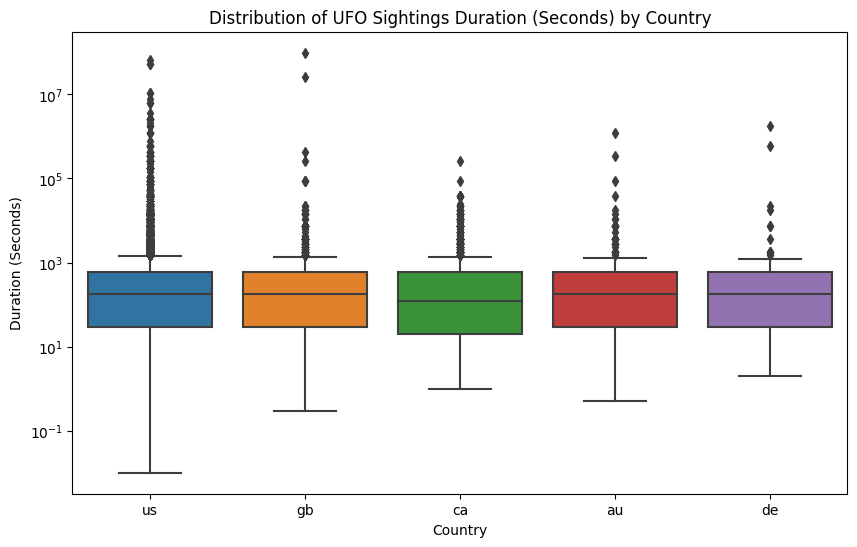

In [30]:
# Visualize the distribution of duration (seconds) by country
plt.figure(figsize=(10,6))
sns.boxplot(x="country", y="duration (seconds)", data=df)
plt.title("Distribution of UFO Sightings Duration (Seconds) by Country")
plt.xlabel("Country")
plt.ylabel("Duration (Seconds)")
plt.yscale("log") # Use log scale to see outliers better
plt.show()

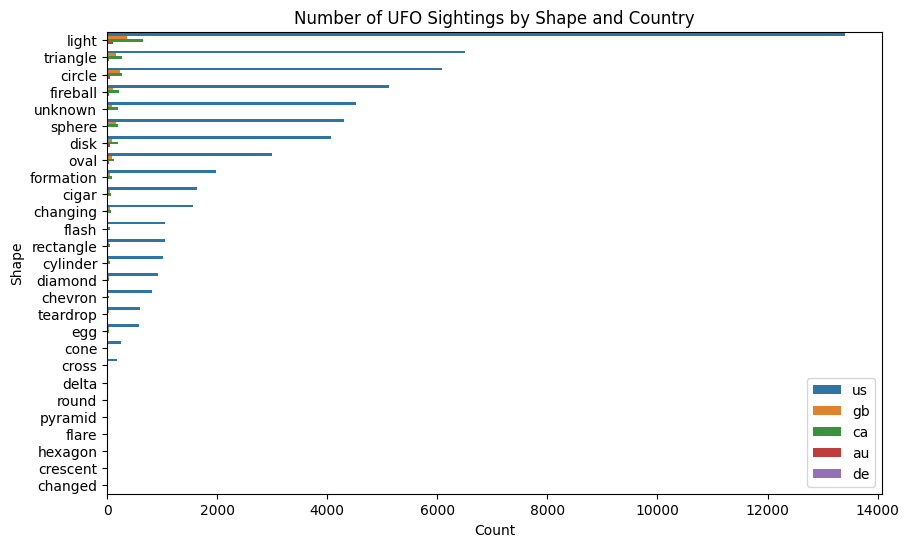

In [31]:
# Visualize the number of sightings by shape and country
plt.figure(figsize=(10,6))
sns.countplot(y="shape", hue="country", data=df, order=df["shape"].value_counts().index)
plt.title("Number of UFO Sightings by Shape and Country")
plt.xlabel("Count")
plt.ylabel("Shape")
plt.legend(loc="lower right")
plt.show()

In [32]:
# Create a new dataframe with only US data
df_us = df[df["country"] == "us"]


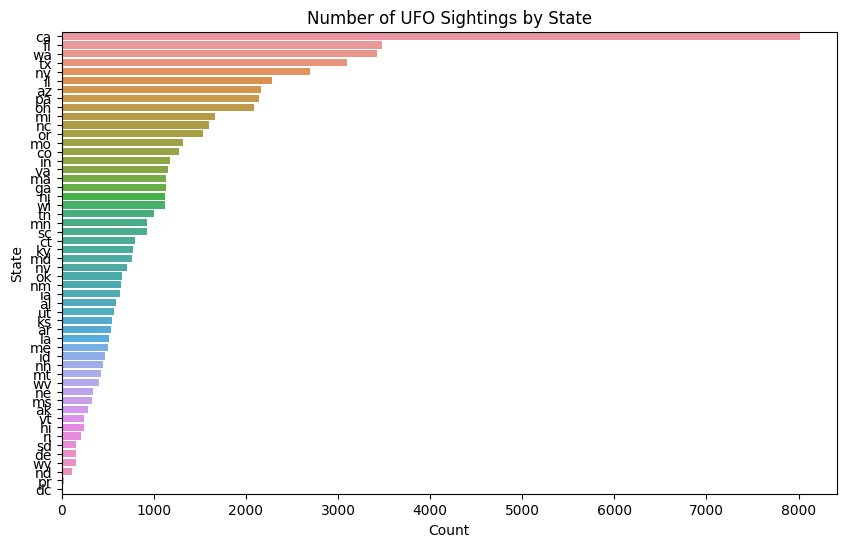

In [33]:
# Visualize the number of sightings by state
plt.figure(figsize=(10,6))
sns.countplot(y="state", data=df_us, order=df_us["state"].value_counts().index)
plt.title("Number of UFO Sightings by State")
plt.xlabel("Count")
plt.ylabel("State")
plt.show()

In [35]:
df = df.dropna()

In [36]:
# Create a linear regression model to predict duration (seconds) based on year and shape
X = pd.get_dummies(df_us[["year", "shape"]], drop_first=True) # Use dummy variables for categorical variables
y = df_us["duration (seconds)"]
X = sm.add_constant(X) # Add a constant term to the model

In [37]:
model = sm.OLS(y, X.astype(float)).fit() # Fit the model using ordinary least squares method

In [38]:
# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     duration (seconds)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4396
Date:                Wed, 24 May 2023   Prob (F-statistic):              0.995
Time:                        23:47:09   Log-Likelihood:            -8.4330e+05
No. Observations:               58685   AIC:                         1.687e+06
Df Residuals:                   58657   BIC:                         1.687e+06
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             4.85e+05   5.45e+05     

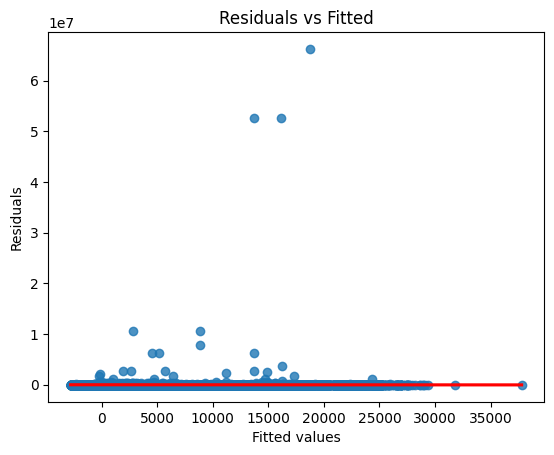

In [39]:
# Create diagnostic plots to check the model assumptions and quality

# Residuals vs Fitted plot
residuals = model.resid # Get the model residuals
fitted = model.fittedvalues # Get the model fitted values
sns.regplot(x=fitted, y=residuals, lowess=True, line_kws={"color": "red"})
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

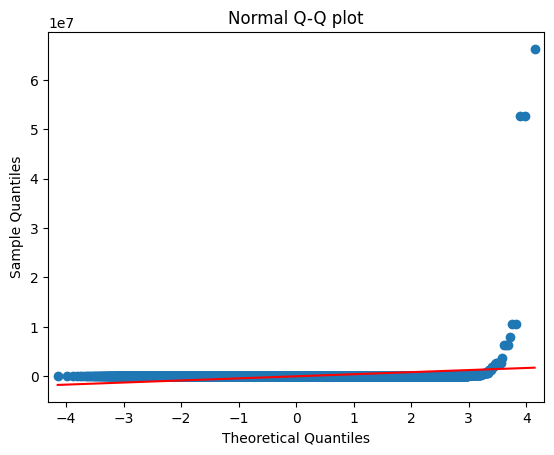

In [40]:
# Normal Q-Q plot
sm.qqplot(residuals, line="s")
plt.title("Normal Q-Q plot")
plt.show()

/home/thechemist54/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:848: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


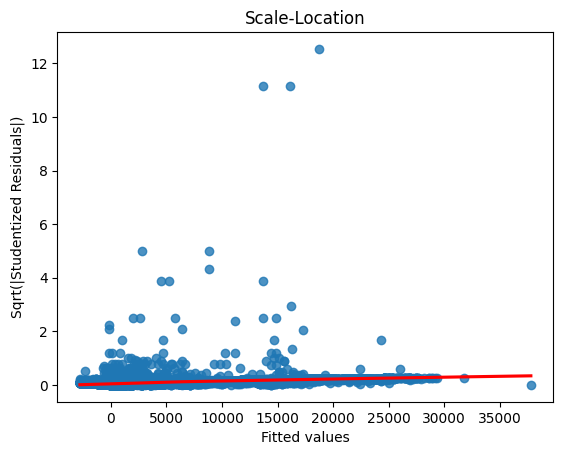

In [41]:
# Scale-Location plot
studentized_residuals = model.get_influence().resid_studentized_internal # Get the studentized residuals
sqrt_studentized_residuals = np.sqrt(np.abs(studentized_residuals)) # Get the square root of studentized residuals
sns.regplot(x=fitted, y=sqrt_studentized_residuals, lowess=True, line_kws={"color": "red"})
plt.xlabel("Fitted values")
plt.ylabel("Sqrt(|Studentized Residuals|)")
plt.title("Scale-Location")
plt.show()

/tmp/ipykernel_17754/656941877.py:10: RuntimeWarning: invalid value encountered in sqrt
  poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
/tmp/ipykernel_17754/656941877.py:11: RuntimeWarning: invalid value encountered in sqrt
  poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
/tmp/ipykernel_17754/656941877.py:12: RuntimeWarning: invalid value encountered in sqrt
  negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
/tmp/ipykernel_17754/656941877.py:13: RuntimeWarning: invalid value encountered in sqrt
  negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)


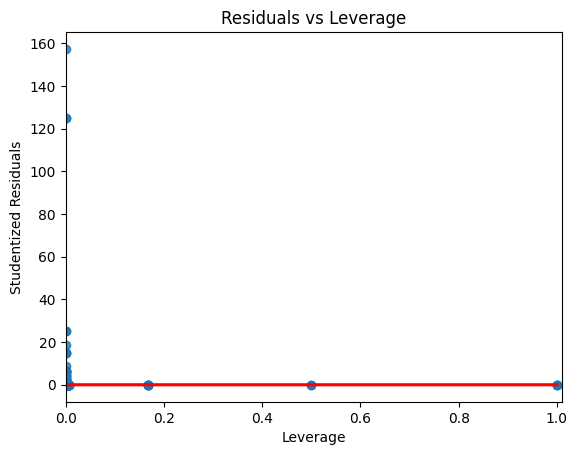

In [43]:
# Residuals vs Leverage plot
leverage = model.get_influence().hat_matrix_diag # Get the leverage values
sns.regplot(x=leverage, y=studentized_residuals, lowess=True, line_kws={"color": "red"})
plt.xlim(0, max(leverage)+0.01)
plt.xlabel("Leverage")
plt.ylabel("Studentized Residuals")
plt.title("Residuals vs Leverage")
cooksx = np.linspace(min(leverage), max(leverage), 50)
p = len(model.params)
poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)

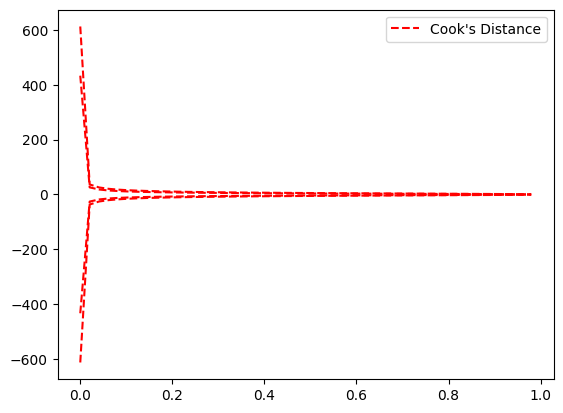

In [44]:
# Plot Cook's distance lines for p-values 0.5 and 1
plt.plot(cooksx, poscooks1y, label="Cook's Distance", ls="--", color="red")
plt.plot(cooksx, poscooks05y, ls="--", color="red")
plt.plot(cooksx, negcooks1y, ls="--", color="red")
plt.plot(cooksx, negcooks05y, ls="--", color="red")
plt.legend(loc="upper right")
plt.show()

In [45]:
# Add more metrics to analyze the data

# Calculate the mean, median, and standard deviation of duration (seconds) by country and shape
df.groupby(["country", "shape"])["duration (seconds)"].agg(["mean", "median", "std"])

mean   median            std
country shape                                          
au      chevron       60.000000     60.0            NaN
        circle       165.000000    165.0     190.918831
        diamond      300.000000    300.0            NaN
        disk         900.000000    900.0            NaN
        light         71.666667     30.0      94.648472
        rectangle    420.000000    420.0            NaN
ca      changing    1248.019118    300.0    2958.674654
        chevron      186.416667     30.0     425.944824
        cigar       1412.472973    120.0    5258.214076
        circle       658.316547    150.0    1684.395248
        cone        2314.500000    300.0    4786.178277
        cross        744.333333     30.0    1193.518538
        cylinder     458.711538    120.0     822.926612
        delta         60.000000     60.0            NaN
        diamond     1375.435897    300.0    2599.461288
        disk        1207.420513    240.0    3254.307477
        egg          688.750000    120.0    1849.990243
        fireball     377.196279     60.0    1154.875733
        flash        672.713115     20.0    2160.419555
        formation    406.442105     50.0     776.503411
        light       1192.605385    120.0    4619.322290
        oval        3037.094488    180.0   23233.699099
        rectangle    396.456522    120.0     757.040134
        sphere      1074.346341    120.0    3015.192819
        teardrop     483.954545    120.0     954.689801
        triangle     623.578947    120.0    2523.012211
        unknown      889.038835    120.0    2129.853919
gb      circle     22125.000000    750.0   42850.233372
        fireball      60.000000     60.0            NaN
        light        390.000000    390.0     296.984848
        sphere       900.000000    900.0            NaN
        triangle     320.000000    320.0     395.979797
us      changed     3600.000000   3600.0            NaN
        changing    2159.434227    450.0    8437.038976
        chevron      486.149815     60.0    1443.960908
        cigar       2191.612477    180.0   45732.324292
        circle      3726.184993    180.0  130217.931900
        cone        1608.483740    300.0    4943.665511
        crescent   37800.000000  37800.0            NaN
        cross        742.864865    240.0    1451.374524
        cylinder    4179.805720    180.0   84114.238748
        delta       2682.500000    360.0    5749.180594
        diamond     1451.965761    300.0    7524.099917
        disk        1423.174504    240.0    9962.024237
        egg         2116.312998    180.0   16941.061970
        fireball    3064.885260    120.0  151662.905567
        flare         30.000000     30.0            NaN
        flash       6474.389727     30.0  134468.295328
        formation   1014.116109    180.0   11453.443445
        hexagon      240.000000    240.0            NaN
        light      15244.466042    180.0  863211.514521
        oval        2269.990679    180.0   43443.473638
        pyramid      120.000000    120.0            NaN
        rectangle    639.601224    180.0    1960.735261
        round        452.500000    452.5     632.860569
        sphere      1599.553121    180.0   23846.900385
        teardrop     940.734746    120.0    7450.292147
        triangle    1441.690633    180.0   34172.446108
        unknown     6282.328966    180.0  186079.870502

In [47]:
# Calculate the correlation matrix of duration (seconds), year, latitude 
df[["duration (seconds)", "year", "latitude"]].corr()

,duration (seconds),year,latitude
duration (seconds),1.000000,-0.004422,-0.005202
year,-0.004422,1.000000,-0.019510
latitude,-0.005202,-0.019510,1.000000


In [48]:
# Create a new column for month 
df["month"] = df["datetime"].dt.month

# Create a new column for day of week 
df["day_of_week"] = df["datetime"].dt.dayofweek

# Calculate the proportion of sightings by month 
df.groupby("month").size() / len(df)


month
1     0.069421
2     0.057479
3     0.067613
4     0.067792
5     0.064957
6     0.097851
7     0.120514
8     0.107936
9     0.096189
10    0.094658
11    0.085225
12    0.070366
dtype: float64

In [49]:
# Calculate the proportion of sightings by day of week 
df.groupby("day_of_week").size() / len(df)


day_of_week
0    0.124603
1    0.134313
2    0.136708
3    0.137197
4    0.144773
5    0.177732
6    0.144675
dtype: float64